In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

model_dict = {
    '2en1de': 'S2V-2L',
    '4en1de': 'S2V-4L',
    '6en1de': 'S2V-6L',
    '2en1de scratch': 'S2V-2L scratch',
    '4en1de scratch': 'S2V-4L scratch',
    '6en1de scratch': 'S2V-6L scratch',
    'wav2vec': 'Wav2Vec2',
    'imagenet': 'ImageNet'
}

In [54]:
model_dir = r'ft_lp_results\5 seeds aggregate results'
data_df = pd.DataFrame()

try:
    file_list = os.listdir(model_dir)
except FileNotFoundError:
    print(f"ERROR: Directory not found at '{model_dir}'")
    file_list = []

for filename in file_list:
    if not filename.endswith('.csv'):
        continue
    if 'std' in filename:
        continue

    model_key = next((key for key in model_dict if filename.startswith(key)), None)

    if 'scratch' in filename and 'lp' in filename:
        training_type = 'scratch lp'
    elif 'scratch+' in filename:
        training_type = 'scratch+'
    elif 'pretrain' in filename:
        training_type = 'pretrain'
    elif 'lp' in filename:
        training_type = 'lp'
    elif 'scratch' in filename:
        training_type = 'scratch'
    else:
        print(f"Warning: Could not determine training type for '{filename}'. Skipping.")
        continue

    if not model_key:
        print(f"Warning: Could not determine model for '{filename}'. Skipping.")
        continue

    file_path = os.path.join(model_dir, filename)
    graphs_file = pd.read_csv(file_path)

    col_name_base = f'{model_key} {training_type}'

    for j in ['train', 'val', 'test']:
        df = pd.DataFrame()

        if j == 'train':
            train_cols = [col for col in graphs_file.columns if ('train' in col) and ('epoch' in col)]
            if not train_cols: continue

            df = graphs_file[train_cols].dropna().reset_index(drop=True)
            df.rename(columns={name: f'{name.removesuffix("_epoch")} - {col_name_base}' for name in df.columns},
                      inplace=True)
        else:
            other_cols = [col for col in graphs_file.columns if j in col]
            if not other_cols: continue

            df = graphs_file[other_cols].dropna().reset_index(drop=True)
            df.rename(columns={name: f'{name} - {col_name_base}' for name in df.columns}, inplace=True)

        data_df = pd.concat((data_df, df), axis=1)

print("--- Final Combined DataFrame (Mean Values Only) ---")
print(data_df.head())
print("\n")
print(f"Any duplicate columns? {data_df.columns.duplicated().any()}")
data_df.info()

--- Final Combined DataFrame (Mean Values Only) ---
   train_acc - 2en1de lp  train_f1 - 2en1de lp  train_loss - 2en1de lp  \
0               0.053687              0.037234                3.539090   
1               0.124484              0.089086                3.128158   
2               0.190954              0.137987                2.831091   
3               0.217896              0.161914                2.635749   
4               0.253294              0.191151                2.522348   

   train_precision - 2en1de lp  train_recall - 2en1de lp  val_acc - 2en1de lp  \
0                     0.037758                  0.037561             0.139233   
1                     0.089643                  0.089839             0.187611   
2                     0.137463                  0.140315             0.231268   
3                     0.161652                  0.164307             0.259587   
4                     0.191446                  0.193117             0.306195   

   val_f1 - 2en1

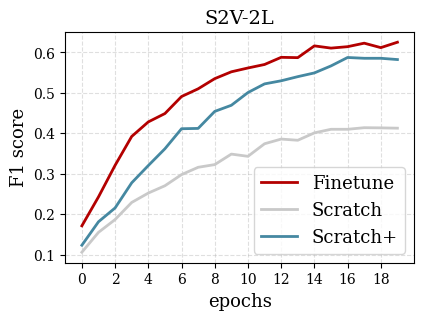

In [58]:
def plot_model_comp(data_type='val', metric='f1', model='2en1de', neg='lp', linewidth=2, save_plot=False):
    font_s = {'family': 'serif', 'weight': 'normal', 'size': 13}
    font_l = {'family': 'serif', 'weight': 'normal', 'size': 14}
    color_map = {
        'Finetune': '#b30000',
        'Scratch': '#c9c9c9',
        'Scratch+': '#4588a1',
        'Linear Probing': '#4588a1'
    }
    plt.figure(figsize=[4.5,3])
    for i in data_df:
        if not neg in i and model in i and metric in i and data_type in i:
            color = 'Finetune' if 'pretrain' in i else 'Scratch+' if 'scratch+' in i else 'Scratch'
            plt.plot(data_df[i][:20], label=color, lw=linewidth, color=color_map[color])
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_entries = dict(zip(labels, handles))

    legend_order = {
        'Finetune' : 'Finetune',
        'Scratch' : 'Scratch',
        'Scratch+': 'Scratch+',
    }

    sorted_handles = [unique_entries[label] for label in legend_order if label in unique_entries]
    sorted_labels = [legend_order[label] for label in legend_order if label in unique_entries]

    plt.legend(sorted_handles, sorted_labels, loc='lower right', prop=font_s)
    plt.xlabel('epochs', fontdict=font_s)
    plt.ylabel('F1 score', fontdict=font_s)
    plt.title(f'{model_dict[model]}', fontdict=font_l)

    plt.xticks(fontname="serif", fontsize=10)
    plt.yticks(fontname="serif", fontsize=10)
    plt.xlim(-1, 20)
    plt.xticks(np.arange(0, 20, 2))
    plt.grid(True, linestyle='--', alpha=0.4)
    if save_plot:
        plt.savefig(os.path.join(model_dir, f'{model}-{metric}.pdf'), bbox_inches='tight', pad_inches=0)
    plt.show()
plot_model_comp(model='2en1de', save_plot=False)

In [24]:
data_df.columns.tolist()

['train_acc - 2en1de lp',
 'train_f1 - 2en1de lp',
 'train_loss - 2en1de lp',
 'train_precision - 2en1de lp',
 'train_recall - 2en1de lp',
 'val_acc - 2en1de lp',
 'val_f1 - 2en1de lp',
 'val_loss - 2en1de lp',
 'val_precision - 2en1de lp',
 'val_recall - 2en1de lp',
 'test_acc - 2en1de lp',
 'test_f1 - 2en1de lp',
 'test_loss - 2en1de lp',
 'test_precision - 2en1de lp',
 'test_recall - 2en1de lp',
 'train_acc - 2en1de pretrain',
 'train_f1 - 2en1de pretrain',
 'train_loss - 2en1de pretrain',
 'train_precision - 2en1de pretrain',
 'train_recall - 2en1de pretrain',
 'val_acc - 2en1de pretrain',
 'val_f1 - 2en1de pretrain',
 'val_loss - 2en1de pretrain',
 'val_precision - 2en1de pretrain',
 'val_recall - 2en1de pretrain',
 'test_acc - 2en1de pretrain',
 'test_f1 - 2en1de pretrain',
 'test_loss - 2en1de pretrain',
 'test_precision - 2en1de pretrain',
 'test_recall - 2en1de pretrain',
 'train_acc - 2en1de scratch+',
 'train_f1 - 2en1de scratch+',
 'train_loss - 2en1de scratch+',
 'train_pr

In [25]:
color_map = {
    '2en1de': '#949494', # dark gray
    '4en1de': '#4588a1', # light blue
    '6en1de': '#b30000', # red
    'imagenet': '#a17c45', # baige
    'wav2vec': '#002966', # dark blue
}

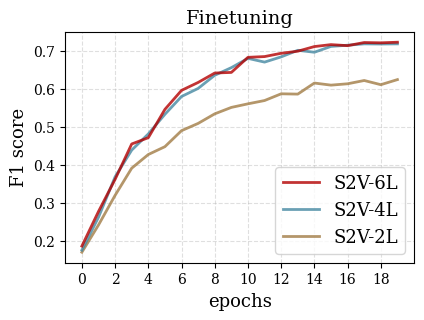

In [61]:
def plot_cross_comp(data_type='val', metric='f1', model='scratch', neg='scratch+', linewidth=2, save_plot=False):
    font_s = {'family': 'serif', 'weight': 'normal', 'size': 13}
    font_l = {'family': 'serif', 'weight': 'normal', 'size': 14}

    color_map = {
        '2en1de': '#a17c45', #949494
        '4en1de': '#4588a1',
        '6en1de': '#b30000',
        'imagenet': '#a17c45',
        'wav2vec': '#002966',
    }
    plt.figure(figsize=[4.5,3])
    for i in data_df:
        if not 'lp' in i and not neg in i and model in i and metric in i and data_type in i and '2en1de' in i:
            plt.plot(data_df[i], label=model_dict['2en1de'], lw=linewidth, color=color_map['2en1de'], alpha=0.8)
        if not neg in i and model in i and metric in i and data_type in i and '4en1de' in i:
            not 'lp' in i and plt.plot(data_df[i], label=model_dict['4en1de'], lw=linewidth, color=color_map['4en1de'], alpha=0.8)
        if not neg in i and model in i and metric in i and data_type in i and '6en1de' in i:
            not 'lp' in i and plt.plot(data_df[i], label=model_dict['6en1de'], lw=linewidth, color=color_map['6en1de'], alpha=0.8)
        '''if not neg in i and model in i and metric in i and data_type in i and 'wav2vec' in i:
            plt.plot(data_df[i], label=model_dict['wav2vec'], lw=linewidth, color=color_map['wav2vec'], alpha=0.8)
        if not neg in i and model in i and metric in i and data_type in i and 'imagenet' in i:
            plt.plot(data_df[i], label=model_dict['imagenet'], lw=linewidth, color=color_map['imagenet'], alpha=0.8)'''
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_entries = dict(zip(labels, handles))

    legend_order = [
        model_dict['6en1de'],
        model_dict['wav2vec'],
        model_dict['imagenet'],
        model_dict['4en1de'],
        model_dict['2en1de'],
    ]

    sorted_handles = [unique_entries[label] for label in legend_order if label in unique_entries]
    sorted_labels = [label for label in legend_order if label in unique_entries]

    plt.legend(sorted_handles, sorted_labels, loc='lower right', prop=font_s)
    plt.xlabel('epochs', fontdict=font_s)
    plt.ylabel('F1 score', fontdict=font_s)
    plt.title('Finetuning', fontdict=font_l)

    plt.xticks(fontname="serif", fontsize=10)
    plt.yticks(fontname="serif", fontsize=10)

    plt.xlim(-1, 20)
    plt.xticks(np.arange(0, 20, 2))
    plt.grid(True, linestyle='--', alpha=0.4)
    if save_plot:
        plt.savefig(os.path.join(model_dir, f'{model}-{metric}.pdf'), bbox_inches='tight', pad_inches=0)
    plt.show()
plot_cross_comp(model='pretrain', neg='scratch', save_plot=False)

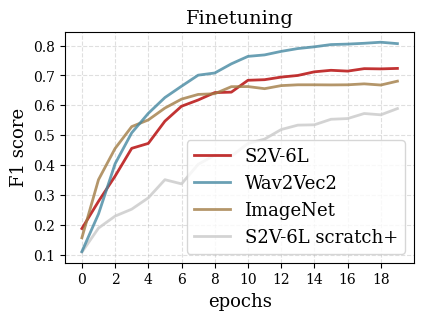

In [71]:
def plot_cross_comp(data_type='val', metric='f1', model='scratch', neg='scratch+', linewidth=2, save_plot=False):
    font_s = {'family': 'serif', 'weight': 'normal', 'size': 13}
    font_l = {'family': 'serif', 'weight': 'normal', 'size': 14}

    color_map = {
        '2en1de': '#a17c45', #949494
        '4en1de': '#b30000',
        '6en1de': '#b30000',
        'imagenet': '#a17c45',
        'wav2vec': '#4588a1',
        'Scratch': '#c9c9c9',
    }
    plt.figure(figsize=[4.5,3])
    for i in data_df:
        '''if not neg in i and model in i and metric in i and data_type in i and '2en1de' in i:
            plt.plot(data_df[i], label=model_dict['2en1de'], lw=linewidth, color=color_map['2en1de'], alpha=0.8)'''
        '''if not neg in i and model in i and metric in i and data_type in i and '4en1de' in i:
            plt.plot(data_df[i], label=model_dict['4en1de'], lw=linewidth, color=color_map['4en1de'], alpha=0.8)'''
        if not neg in i and model in i and metric in i and data_type in i and '6en1de' in i:
            plt.plot(data_df[i], label=model_dict['6en1de'], lw=linewidth, color=color_map['6en1de'], alpha=0.8)
        if not neg in i and model in i and metric in i and data_type in i and 'wav2vec' in i:
            plt.plot(data_df[i], label=model_dict['wav2vec'], lw=linewidth, color=color_map['wav2vec'], alpha=0.8)
        if not neg in i and model in i and metric in i and data_type in i and 'imagenet' in i:
            plt.plot(data_df[i], label=model_dict['imagenet'], lw=linewidth, color=color_map['imagenet'], alpha=0.8)
        if not any(keyword in i for keyword in [model, 'lp']) and 'scratch+' in i and metric in i and data_type in i and '6en1de' in i:
            plt.plot(data_df[i], label=f"S2V-6L scratch+", lw=linewidth, color=color_map['Scratch'], alpha=0.8)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_entries = dict(zip(labels, handles))

    legend_order = [
        model_dict['6en1de'],
        model_dict['4en1de'],
        model_dict['wav2vec'],
        model_dict['imagenet'],
        model_dict['2en1de'],
        f"S2V-6L scratch+"

    ]

    sorted_handles = [unique_entries[label] for label in legend_order if label in unique_entries]
    sorted_labels = [label for label in legend_order if label in unique_entries]

    plt.legend(sorted_handles, sorted_labels, loc='lower right', prop=font_s)
    plt.xlabel('epochs', fontdict=font_s)
    plt.ylabel('F1 score', fontdict=font_s)
    plt.title('Finetuning', fontdict=font_l)

    plt.xticks(fontname="serif", fontsize=10)
    plt.yticks(fontname="serif", fontsize=10)

    plt.xlim(-1, 20)
    plt.xticks(np.arange(0, 20, 2))
    plt.grid(True, linestyle='--', alpha=0.4)
    if save_plot:
        plt.savefig(os.path.join(model_dir, f'all-{model}-{metric}.pdf'), bbox_inches='tight', pad_inches=0)
    plt.show()
plot_cross_comp(model='pretrain', neg='scratch', save_plot=False)

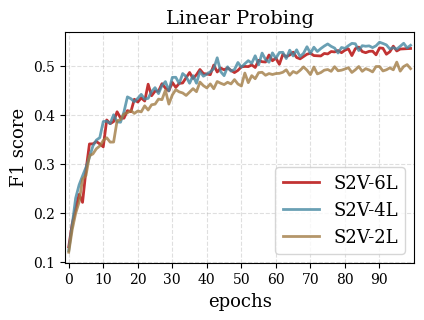

In [63]:
def plot_lp(data_type='val', metric='f1', model='scratch', neg='scratch+', linewidth=2, save_plot=False):
    font_s = {'family': 'serif', 'weight': 'normal', 'size': 13}
    font_l = {'family': 'serif', 'weight': 'normal', 'size': 14}
    color_map = {
        '2en1de': '#a17c45',
        '4en1de': '#4588a1',
        '6en1de': '#b30000',
    }

    if model == 'lp':
        plt.figure(figsize=[4.5,3])
    else:
        plt.figure(figsize=[4.5,3])


    plot_order = ['6en1de', '4en1de', '2en1de']

    for key in plot_order:
        for col_name in data_df:
            if key in col_name and model in col_name and metric in col_name and data_type in col_name and neg not in col_name:
                plt.plot(data_df[col_name],
                         label=model_dict[key],
                         lw=linewidth,
                         color=color_map[key],
                         alpha=0.8)
                break

    handles, labels = plt.gca().get_legend_handles_labels()
    unique_entries = dict(zip(labels, handles))

    legend_order = [model_dict[key] for key in plot_order]

    sorted_handles = [unique_entries[label] for label in legend_order if label in unique_entries]
    sorted_labels = [label for label in legend_order if label in unique_entries]

    plt.legend(sorted_handles, sorted_labels, loc='lower right', prop=font_s)

    plt.xlabel('epochs', fontdict=font_s)
    plt.ylabel('F1 score', fontdict=font_s)
    plt.title('Linear Probing', fontdict=font_l)

    plt.xticks(fontname="serif", fontsize=10)
    plt.yticks(fontname="serif", fontsize=10)

    if model == 'lp':
        plt.xlim(-1, 100)
        plt.xticks(np.arange(0, 100, 10))
    else:
        plt.xlim(-1, 20)
        plt.xticks(np.arange(0, 20, 2))

    plt.grid(True, linestyle='--', alpha=0.4)
    if save_plot:
        plt.savefig(os.path.join(model_dir, f'{model}-mae-{metric}.pdf'), bbox_inches='tight', pad_inches=0)
    plt.show()

plot_lp(model='lp', neg='scratch', save_plot=False)

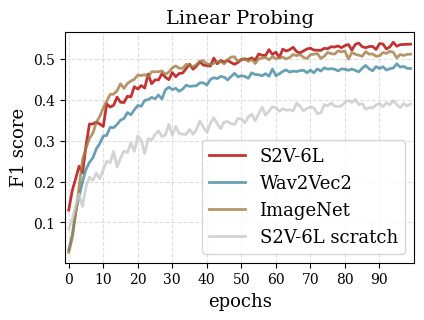

In [72]:
def plot_lp(data_type='val', metric='f1', enc='4en1de', model='scratch', neg='scratch+', linewidth=2, save_plot=False):
    font_s = {'family': 'serif', 'weight': 'normal', 'size': 13}
    font_l = {'family': 'serif', 'weight': 'normal', 'size': 14}
    color_map = {
        f'{enc}': '#b30000',
        'wav2vec': '#4588a1',
        'imagenet': '#a17c45',
        f'{enc} scratch': '#c9c9c9',
    }

    if model == 'lp':
        plt.figure(figsize=[4.5,3])
    else:
        plt.figure(figsize=[4.5,3])


    plot_order = [f'{enc}', 'wav2vec', 'imagenet', f'{enc} scratch']

    for key in plot_order:
        for col_name in data_df:
            if key in col_name and model in col_name and metric in col_name and data_type in col_name and neg not in col_name:
                plt.plot(data_df[col_name],
                         label=model_dict[key],
                         lw=linewidth,
                         color=color_map[key],
                         alpha=0.8)
                break

    handles, labels = plt.gca().get_legend_handles_labels()
    unique_entries = dict(zip(labels, handles))

    legend_order = [model_dict[key] for key in plot_order]

    sorted_handles = [unique_entries[label] for label in legend_order if label in unique_entries]
    sorted_labels = [label for label in legend_order if label in unique_entries]

    plt.legend(sorted_handles, sorted_labels, loc='lower right', prop=font_s)

    plt.xlabel('epochs', fontdict=font_s)
    plt.ylabel('F1 score', fontdict=font_s)
    plt.title('Linear Probing', fontdict=font_l)

    plt.xticks(fontname="serif", fontsize=10)
    plt.yticks(fontname="serif", fontsize=10)

    if model == 'lp':
        plt.xlim(-1, 100)
        plt.xticks(np.arange(0, 100, 10))
    else:
        plt.xlim(-1, 20)
        plt.xticks(np.arange(0, 20, 2))

    plt.grid(True, linestyle='--', alpha=0.4)
    if save_plot:
        plt.savefig(os.path.join(model_dir, f'all-{model}-{metric}.pdf'), bbox_inches='tight', pad_inches=0)
    plt.show()

plot_lp(enc='6en1de', model='lp', neg='-1', save_plot=True)

In [30]:
data_df.columns.tolist()

['train_acc - 2en1de lp',
 'train_f1 - 2en1de lp',
 'train_loss - 2en1de lp',
 'train_precision - 2en1de lp',
 'train_recall - 2en1de lp',
 'val_acc - 2en1de lp',
 'val_f1 - 2en1de lp',
 'val_loss - 2en1de lp',
 'val_precision - 2en1de lp',
 'val_recall - 2en1de lp',
 'test_acc - 2en1de lp',
 'test_f1 - 2en1de lp',
 'test_loss - 2en1de lp',
 'test_precision - 2en1de lp',
 'test_recall - 2en1de lp',
 'train_acc - 2en1de pretrain',
 'train_f1 - 2en1de pretrain',
 'train_loss - 2en1de pretrain',
 'train_precision - 2en1de pretrain',
 'train_recall - 2en1de pretrain',
 'val_acc - 2en1de pretrain',
 'val_f1 - 2en1de pretrain',
 'val_loss - 2en1de pretrain',
 'val_precision - 2en1de pretrain',
 'val_recall - 2en1de pretrain',
 'test_acc - 2en1de pretrain',
 'test_f1 - 2en1de pretrain',
 'test_loss - 2en1de pretrain',
 'test_precision - 2en1de pretrain',
 'test_recall - 2en1de pretrain',
 'train_acc - 2en1de scratch+',
 'train_f1 - 2en1de scratch+',
 'train_loss - 2en1de scratch+',
 'train_pr

## Test set performance results

In [2]:
model_dir = r'ft_lp_results\5 seeds aggregate results'
results_list = []

try:
    file_list = os.listdir(model_dir)
except FileNotFoundError:
    print(f"ERROR: Directory not found at '{model_dir}'")
    file_list = []

METRICS_TO_EXTRACT = ['test_f1']

for filename in file_list:
    if not filename.endswith('mean.csv'):
        continue

    run_name = filename.removesuffix(' mean.csv')
    model_key = next((key for key in model_dict if filename.startswith(key)), 'unknown')
    base_model = model_dict.get(model_key, 'Unknown')

    mean_filepath = os.path.join(model_dir, filename)
    std_filepath = mean_filepath.replace('mean.csv', 'std.csv')

    if not os.path.exists(std_filepath):
        print(f"Warning: Std file not found for '{filename}'. Skipping.")
        continue

    try:
        mean_metrics = pd.read_csv(mean_filepath).iloc[-1]
        std_metrics = pd.read_csv(std_filepath).iloc[-1]

        data_row = {
            'run_name': run_name,
            'base_model': base_model
        }

        for metric in METRICS_TO_EXTRACT:
            if metric in mean_metrics and metric in std_metrics:
                data_row[f'{metric}_mean'] = mean_metrics[metric]
                data_row[f'{metric}_stdv'] = std_metrics[metric]

        results_list.append(data_row)

    except Exception as e:
        print(f"ERROR: Could not process file '{filename}'. Reason: {e}")
        continue

results_df = pd.DataFrame(results_list)

print("--- Detailed Test Metrics from All Files ---")
print(results_df)

if not results_df.empty and 'test_f1_mean' in results_df.columns:
    results_df['f1_formatted'] = (
        (results_df['test_f1_mean'] * 100).round(1).astype(str) +
        ' ± ' +
        (results_df['test_f1_stdv'] * 100).round(1).astype(str)
    )

    sorted_df = results_df.sort_values(by=['base_model', 'run_name'])

    print("\n\n--- Formatted Results Table ---")

    print(sorted_df[['base_model', 'run_name', 'f1_formatted']])

--- Detailed Test Metrics from All Files ---
                        run_name base_model  test_f1_mean  test_f1_stdv
0           2en1de - lp-mean.csv     S2V-2L      0.513471      0.008399
1     2en1de - pretrain-mean.csv     S2V-2L      0.633825      0.013591
2     2en1de - scratch+-mean.csv     S2V-2L      0.569912      0.006599
3      2en1de - scratch-mean.csv     S2V-2L      0.384071      0.004720
4   2en1de scratch - lp-mean.csv     S2V-2L      0.420649      0.012705
5           4en1de - lp-mean.csv     S2V-4L      0.542183      0.005478
6     4en1de - pretrain-mean.csv     S2V-4L      0.688889      0.016140
7     4en1de - scratch+-mean.csv     S2V-4L      0.571878      0.016283
8      4en1de - scratch-mean.csv     S2V-4L      0.420059      0.012413
9   4en1de scratch - lp-mean.csv     S2V-4L      0.421632      0.007852
10          6en1de - lp-mean.csv     S2V-6L      0.535890      0.010627
11    6en1de - pretrain-mean.csv     S2V-6L      0.706982      0.006698
12    6en1de - scra